In [1]:
# Import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack
import pickle

# NOTE:  Before running code below, download the following:  nltk.download('punkt')
# nltk.download('punkt')


In [2]:
# Read in Cleaned TV Show data
shows = pd.read_csv('../csv/tv_shows_data_cleaned.csv')
shows.head()

,id,name,original_name,genre_name,number_of_seasons,number_of_episodes,first_air_date,last_air_date,in_production,popularity,...,vote_count,origin_country,original_language,overview,tagline,creator_names,production_names,production_logo_paths,production_origin_countries,poster_path
0,25,Star Wars: Droids,Star Wars: Droids,"Kids, Animation, Action & Adventure, Sci-Fi & ...",1,13,1985-09-07,1985-11-30,False,11.592,...,66,"[""CA"",""US""]",en,An animated television series that features th...,NaN,"['George Lucas', 'Ben Burtt', 'Clive A. Smith'...","['Lucasfilm Animation', 'Lucasfilm Ltd.']","['/eDWGeg5tdVNcI8aBaaJ21bEBtFa.png', '/o86Dbpb...","['US', 'US']",/b3gsZSTauRBJDJvWCbD9oVAsFe1.jpg
1,29,"Mary Hartman, Mary Hartman","Mary Hartman, Mary Hartman","Drama, Soap, Comedy",2,307,1976-01-05,1977-03-10,False,14.367,...,8,"[""US""]",en,"In the fictional town of Fernwood, Ohio, subur...",NaN,"['Gail Parent', 'Norman Lear', 'Ann Marcus', '...",['TAT Communications Company'],[None],[''],/O1bcYEBW8v7JOMNVpYOBTL6PjL.jpg
2,55,North of 60,North of 60,Drama,6,95,1992-12-03,2005-01-30,False,5.742,...,42,"[""CA""]",en,North of 60 is a mid-1990s Canadian television...,NaN,NaN,NaN,NaN,NaN,/twsoO8NCTitfW4My9wKz2p5yJou.jpg
3,65,The Job,The Job,"Drama, Comedy",2,19,2001-03-14,2002-04-24,False,6.335,...,53,"[""US""]",en,Mike McNeil is a decorated New York City detec...,NaN,"['Denis Leary', 'Peter Tolan']","['The Cloudland Company', 'Apostle', 'Touchsto...","[None, None, '/wwaKUcOENHix2jxLfFBfNkCtOEQ.png...","['US', 'US', 'US', 'US']",/iDiiIBZCjdihpBoDKzVRhb7C9B.jpg
4,70,This Hour Has 22 Minutes,This Hour Has 22 Minutes,"News, Comedy",30,386,2009-09-28,2023-02-21,True,15.032,...,46,"[""CA""]",en,This Hour Has 22 Minutes is a weekly Canadian ...,NaN,"['Mary Walsh', 'Rick Mercer']",NaN,NaN,NaN,/7sP1tv9e2wZzdOATVZxtZN3DUbi.jpg


In [3]:
# View datafram description
shows.describe()

,id,number_of_seasons,number_of_episodes,popularity,vote_average,vote_count
count,5219.000000,5219.000000,5219.000000,5219.000000,5219.000000,5219.000000
mean,58651.786358,3.901514,83.422495,15.157858,7.044878,145.861851
std,53564.505074,6.192352,329.111127,35.214720,1.049567,708.405646
min,9.000000,1.000000,0.000000,0.600000,1.400000,5.000000
25%,9786.000000,1.000000,7.000000,3.265000,6.500000,8.000000
50%,58699.000000,2.000000,20.000000,6.239000,7.200000,16.000000
75%,87924.500000,4.000000,65.000000,13.651500,7.714000,55.000000
max,225875.000000,79.000000,8903.000000,649.708000,10.000000,21048.000000


In [4]:
# View the dataframe data types
shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5219 entries, 0 to 5218
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5219 non-null   int64  
 1   name                         5219 non-null   object 
 2   original_name                5219 non-null   object 
 3   genre_name                   5098 non-null   object 
 4   number_of_seasons            5219 non-null   int64  
 5   number_of_episodes           5219 non-null   int64  
 6   first_air_date               5207 non-null   object 
 7   last_air_date                5216 non-null   object 
 8   in_production                5219 non-null   bool   
 9   popularity                   5219 non-null   float64
 10  vote_average                 5219 non-null   float64
 11  vote_count                   5219 non-null   int64  
 12  origin_country               5219 non-null   object 
 13  original_language 

In [5]:
# Drop rows with null genre_name
shows.dropna(subset=['genre_name'], inplace=True)
shows.dropna(subset=['overview'], inplace=True)

In [6]:
# Print out unique genres
unique_values = shows['genre_name'].unique()
print(unique_values)

['Kids, Animation, Action & Adventure, Sci-Fi & Fantasy'
 'Drama, Soap, Comedy' 'Drama' 'Drama, Comedy' 'News, Comedy' 'Comedy'
 'Crime, Drama' 'Animation, Sci-Fi & Fantasy, Action & Adventure, Comedy'
 'Comedy, Family, Drama' 'Action & Adventure, Animation, Family, Kids'
 'Sci-Fi & Fantasy, Action & Adventure, Drama' 'Reality'
 'Western, Animation, Family' 'Animation' 'Documentary, Talk, Comedy'
 'News' 'Sci-Fi & Fantasy, Comedy, Drama, Action & Adventure'
 'Action & Adventure, Sci-Fi & Fantasy' 'Family, Animation' 'Comedy, Kids'
 'Action & Adventure, Drama, Sci-Fi & Fantasy' 'Animation, Comedy, Drama'
 'Animation, Action & Adventure' 'Animation, Comedy, Kids'
 'Family, Animation, Kids' 'Mystery, Drama'
 'Animation, Sci-Fi & Fantasy, Comedy'
 'Family, Sci-Fi & Fantasy, Comedy, Drama'
 'Animation, Comedy, Action & Adventure, Sci-Fi & Fantasy' 'Comedy, Drama'
 'Kids' 'War & Politics, Action & Adventure'
 'Action & Adventure, Animation, Comedy, Sci-Fi & Fantasy'
 'Drama, Action & Adventu

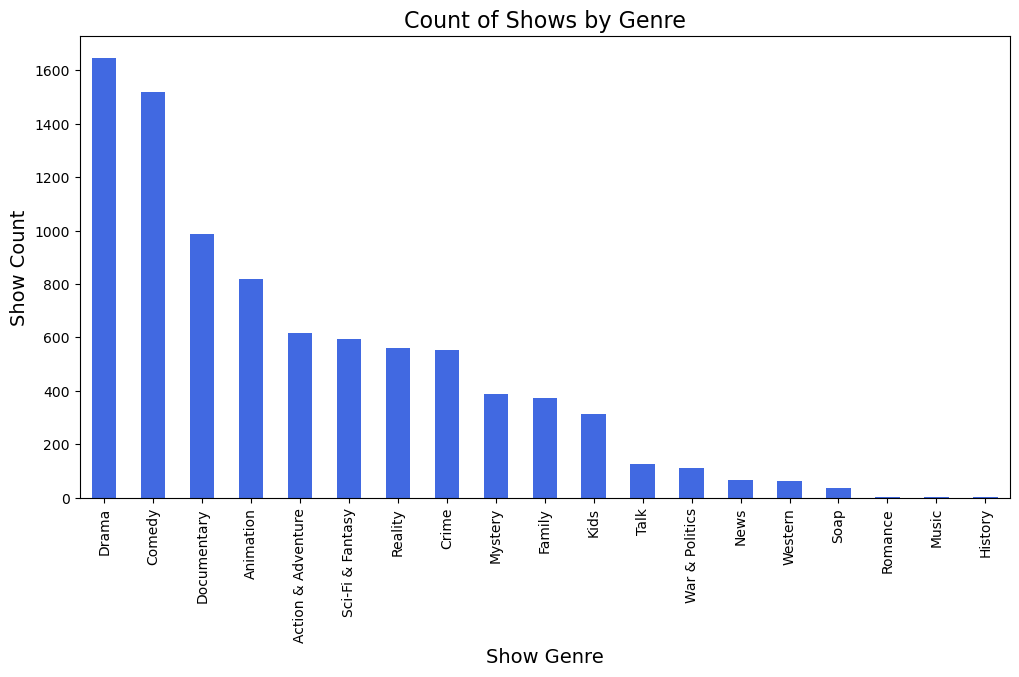

In [7]:
# Create DataFrame with genre counts
genre_counts = shows['genre_name'].str.split(', ').explode().value_counts()

# Plot bar chart
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar',color="royalblue")
plt.title('Count of Shows by Genre', fontsize=16)
plt.xlabel('Show Genre', fontsize=14)
plt.ylabel('Show Count', fontsize=14)
plt.xticks(rotation=90)
plt.show()


In [8]:
# Group by vote_average and get counts
vote_average_counts = shows['vote_average'].value_counts()
vote_average_counts

7.000    152
7.200    134
6.800    133
7.500    122
7.300    117
        ... 
5.369      1
6.901      1
7.092      1
8.056      1
7.068      1
Name: vote_average, Length: 1417, dtype: int64

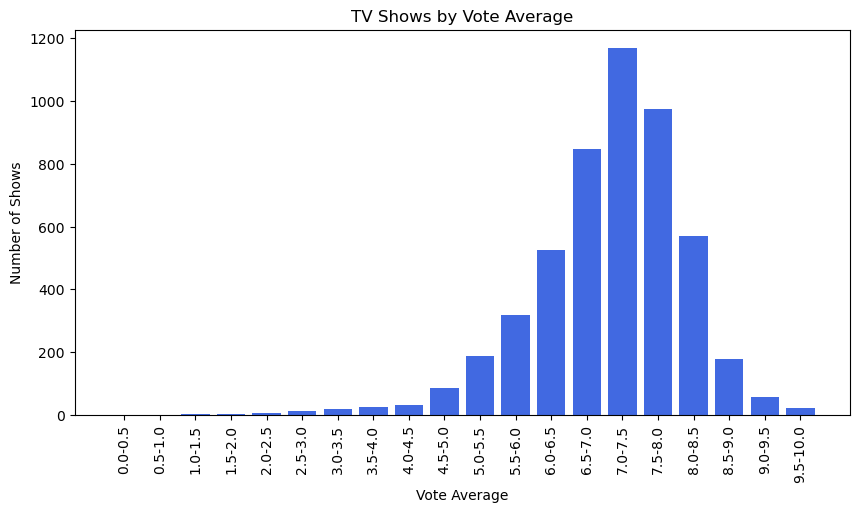

In [9]:
# Bin the vote_average values
bins = np.arange(0, 10.5, 0.5)
labels = [f'{x}-{x+0.5}' for x in bins[:-1]]
shows['vote_average_bins'] = pd.cut(shows['vote_average'], bins=bins, labels=labels, right=False)

# Count the number of shows in each bin
vote_counts = shows['vote_average_bins'].value_counts().sort_index()

# Set the figure size
plt.figure(figsize=(10, 5))  # Adjust the width and height values as desired

# Plot the histogram
plt.bar(vote_counts.index, vote_counts.values, color="royalblue")
plt.xlabel('Vote Average')
plt.ylabel('Number of Shows')
plt.title('TV Shows by Vote Average')

# Rotate x-labels
plt.xticks(rotation='vertical')

plt.savefig('../graphs/vote_average_histogram.png', dpi=800)
plt.show()



# Features = genres, overview, creator names

## CountVectorizer Model

In [10]:
# Load the dataframe
shows_1 = pd.read_csv('../csv/tv_shows_data_cleaned.csv')

# Preprocessing
shows_1 = shows_1.drop(["id", "original_name", "number_of_seasons", "first_air_date", "last_air_date",
                        "in_production", "origin_country", "original_language", "tagline",
                        "production_names", "production_logo_paths", "production_origin_countries", "poster_path"], axis=1)

# Fill missing values with an empty string
shows_1["overview"].fillna("", inplace=True)  
shows_1["genre_name"].fillna("", inplace=True) 
shows_1["creator_names"].fillna("", inplace=True) 

# Text vectorization
overview_vectorizer = CountVectorizer(stop_words="english")
overview_vectors = overview_vectorizer.fit_transform(shows_1["overview"])

genre_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
genre_vectors = genre_vectorizer.fit_transform(shows_1["genre_name"])

creator_vectorizer = CountVectorizer()
creator_vectors = creator_vectorizer.fit_transform(shows_1["creator_names"])

# Concatenate feature vectors
combined_vectors = hstack((overview_vectors, genre_vectors, creator_vectors))

# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(combined_vectors)

# Define recommendation function
def cv_recommend_similar_shows(show_title, num_recommendations=5):
    show_index = shows_1[shows_1["name"] == show_title].index[0]
    similarity_scores = list(enumerate(cosine_sim[show_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similar_show_indices = [index for index, _ in similarity_scores[1:num_recommendations+1]]
    recommended_shows = shows_1.loc[similar_show_indices, "name"]
    return recommended_shows




## TfidfVectorizer Model - USE AS THE FINAL ML TV SHOW MODEL

In [11]:
# Load the dataframe
shows_2 = pd.read_csv('../csv/tv_shows_data_cleaned.csv')

# Preprocessing
shows_2 = shows_2.drop(["id", "original_name", "number_of_seasons", "first_air_date", "last_air_date",
                        "in_production", "origin_country", "original_language", "tagline",
                        "production_names", "production_logo_paths", "production_origin_countries"], axis=1)

# Fill missing values with an empty string
shows_2["overview"].fillna("", inplace=True)  
shows_2["genre_name"].fillna("", inplace=True) 
shows_2["creator_names"].fillna("", inplace=True) 

# Text vectorization
overview_vectorizer = TfidfVectorizer(stop_words="english")
overview_vectors_final = overview_vectorizer.fit_transform(shows_2["overview"])

genre_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(', '))
genre_vectors_final = genre_vectorizer.fit_transform(shows_2["genre_name"])

creator_vectorizer = TfidfVectorizer()
creator_vectors_final = creator_vectorizer.fit_transform(shows_2["creator_names"])

# Concatenate feature vectors
combined_vectors_final = hstack((overview_vectors_final, genre_vectors_final, creator_vectors_final))

# Calculate cosine similarity matrix
cosine_sim_final = cosine_similarity(combined_vectors)

# Define recommendation function
def tfidf_recommend_similar_shows_FINAL(show_title, num_recommendations=5):
    show_index = shows_2[shows_2["name"] == show_title].index[0]
    similarity_scores = list(enumerate(cosine_sim_final[show_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similar_show_indices = [index for index, _ in similarity_scores[1:num_recommendations+1]]
    recommended_shows = shows_2.loc[similar_show_indices, "name"]
    return recommended_shows




In [12]:
# TfidfVectorizer: Make recommendation
input_show = "Game of Thrones"
recommendations = tfidf_recommend_similar_shows_FINAL(input_show)
print(f"TfidfVectorizer model recommended shows similar to '{input_show}':")
print(recommendations)

TfidfVectorizer model recommended shows similar to 'Game of Thrones':
3356                           Fate/Apocrypha
1086                                Dogfights
2774                                 The Game
2569    The Magical Legend of the Leprechauns
1595                 The Chronicles of Narnia
Name: name, dtype: object


In [13]:
# Save the final dataframe shows_2 to csv file
shows_2.to_csv('../csv/tv_shows_final.csv')

In [14]:
# Save the final vector to a pickle file
pickle.dump(combined_vectors_final,open('../pkl/combined_vectors_final.pkl','wb'))

## KNN Model

In [15]:
# Load the dataframe
shows_3 = pd.read_csv('../csv/tv_shows_data_cleaned.csv')

# Preprocessing
shows_3 = shows_3.drop(["id", "original_name", "number_of_seasons", "first_air_date", "last_air_date",
                        "in_production", "origin_country", "original_language", "tagline",
                        "production_names", "production_logo_paths", "production_origin_countries", "poster_path"], axis=1)

# Fill missing values with an empty string
shows_3["overview"].fillna("", inplace=True)  
shows_3["genre_name"].fillna("", inplace=True) 
shows_3["creator_names"].fillna("", inplace=True) 
# shows_3 = shows_3.dropna(subset=["genre_name", "number_of_episodes", "creator_names"])

# Text vectorization
overview_vectorizer = TfidfVectorizer(stop_words="english")
overview_vectors = overview_vectorizer.fit_transform(shows_3["overview"])

genre_vectorizer = TfidfVectorizer()
genre_vectors = genre_vectorizer.fit_transform(shows_3["genre_name"])

creator_vectorizer = TfidfVectorizer()
creator_vectors = creator_vectorizer.fit_transform(shows_3["creator_names"])

# Concatenate feature vectors
combined_vectors = hstack((overview_vectors, genre_vectors, creator_vectors))

# Build the similarity calculation
knn_model = NearestNeighbors(metric="cosine")
knn_model.fit(combined_vectors)

# Define recommendation function
def knn_recommend_similar_shows(show_title, num_recommendations=5):
    show_index = shows_3[shows_3["name"] == show_title].index[0]
    _, indices = knn_model.kneighbors(combined_vectors[show_index], n_neighbors=num_recommendations+1)
    recommended_show_indices = indices.flatten()[1:]
    recommended_shows = shows_3.loc[recommended_show_indices, "name"]
    return recommended_shows


### Recommendations

In [16]:
# CountVectorizer:  Make recommendation
input_show = "Game of Thrones"
recommendations = cv_recommend_similar_shows(input_show)
print(f"CountVectorizer model ecommended shows similar to '{input_show}':")
print(recommendations)

CountVectorizer model ecommended shows similar to 'Game of Thrones':
3356                           Fate/Apocrypha
1086                                Dogfights
2774                                 The Game
2569    The Magical Legend of the Leprechauns
1595                 The Chronicles of Narnia
Name: name, dtype: object


In [17]:
# TfidfVectorizer: Make recommendation
input_show = "Game of Thrones"
recommendations = tfidf_recommend_similar_shows(input_show)
print(f"TfidfVectorizer model recommended shows similar to '{input_show}':")
print(recommendations)

TfidfVectorizer model recommended shows similar to 'Game of Thrones':
3356                           Fate/Apocrypha
1086                                Dogfights
2774                                 The Game
2569    The Magical Legend of the Leprechauns
1595                 The Chronicles of Narnia
Name: name, dtype: object


In [18]:
# KNN: Make recommendation
input_show = "Game of Thrones"
recommendations = knn_recommend_similar_shows(input_show)
print(f"KNN Model recommended shows similar to '{input_show}':")
print(recommendations)

KNN Model recommended shows similar to 'Game of Thrones':
3356                                Fate/Apocrypha
1595                      The Chronicles of Narnia
3204    Marvel's Agents of S.H.I.E.L.D.: Slingshot
2353                                    Riverworld
2294                                 The Borrowers
Name: name, dtype: object


# Features = genres, overview, creator names & POPULARITY

## CountVectorizer Model

In [19]:
# Load the dataframe
shows_4 = pd.read_csv('../csv/tv_shows_data_cleaned.csv')

# Preprocessing
shows_4 = shows_4.drop(["id", "original_name", "number_of_seasons", "first_air_date", "last_air_date",
                        "in_production", "origin_country", "original_language", "tagline",
                        "production_names", "production_logo_paths", "production_origin_countries", "poster_path"], axis=1)

# Fill missing values with an empty string
shows_4["overview"].fillna("", inplace=True)  
shows_4["genre_name"].fillna("", inplace=True) 
shows_4["creator_names"].fillna("", inplace=True) 
shows_4["popularity"].fillna("", inplace=True) 

# Text vectorization
overview_vectorizer = CountVectorizer(stop_words="english")
overview_vectors = overview_vectorizer.fit_transform(shows_4["overview"])

genre_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
genre_vectors = genre_vectorizer.fit_transform(shows_4["genre_name"])

creator_vectorizer = CountVectorizer()
creator_vectors = creator_vectorizer.fit_transform(shows_4["creator_names"])

# Add popularity as a separate feature vector
popularity_vector = shows_4["popularity"].values.reshape(-1, 1)

# Concatenate feature vectors
combined_vectors = hstack((overview_vectors, genre_vectors, creator_vectors, popularity_vector))

# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(combined_vectors)

# Define recommendation function
def cv_recommend_similar_shows_2(show_title, num_recommendations=5):
    show_index = shows_4[shows_4["name"] == show_title].index[0]
    similarity_scores = list(enumerate(cosine_sim[show_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similar_show_indices = [index for index, _ in similarity_scores[1:num_recommendations+1]]
    recommended_shows = shows_1.loc[similar_show_indices, "name"]
    return recommended_shows



## TfidfVectorizer

In [20]:
# Load the dataframe
shows_5 = pd.read_csv('../csv/tv_shows_data_cleaned.csv')

# Preprocessing
shows_5 = shows_5.drop(["id", "original_name", "number_of_seasons", "first_air_date", "last_air_date",
                        "in_production", "origin_country", "original_language", "tagline",
                        "production_names", "production_logo_paths", "production_origin_countries", "poster_path"], axis=1)

# Fill missing values with an empty string
shows_5["overview"].fillna("", inplace=True)  
shows_5["genre_name"].fillna("", inplace=True) 
shows_5["creator_names"].fillna("", inplace=True) 
shows_5["popularity"].fillna("", inplace=True) 

# Text vectorization
overview_vectorizer = TfidfVectorizer(stop_words="english")
overview_vectors = overview_vectorizer.fit_transform(shows_5["overview"])

genre_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(', '))
genre_vectors = genre_vectorizer.fit_transform(shows_5["genre_name"])

creator_vectorizer = TfidfVectorizer()
creator_vectors = creator_vectorizer.fit_transform(shows_5["creator_names"])


# Add popularity as a separate feature vector
popularity_vector = shows_5["popularity"].values.reshape(-1, 1)

# Concatenate feature vectors
combined_vectors = hstack((overview_vectors, genre_vectors, creator_vectors, popularity_vector))


# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(combined_vectors)

# Define recommendation function
def tfidf_recommend_similar_shows_2(show_title, num_recommendations=5):
    show_index = shows_5[shows_5["name"] == show_title].index[0]
    similarity_scores = list(enumerate(cosine_sim[show_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similar_show_indices = [index for index, _ in similarity_scores[1:num_recommendations+1]]
    recommended_shows = shows_5.loc[similar_show_indices, "name"]
    return recommended_shows



## KNN Model

In [21]:
# Load the dataframe
shows_6 = pd.read_csv('../csv/tv_shows_data_cleaned.csv')

# Preprocessing
shows_6 = shows_6.drop(["id", "original_name", "number_of_seasons", "first_air_date", "last_air_date",
                        "in_production", "origin_country", "original_language", "tagline",
                        "production_names", "production_logo_paths", "production_origin_countries", "poster_path"], axis=1)

# Fill missing values with an empty string
shows_6["overview"].fillna("", inplace=True)  
shows_6["genre_name"].fillna("", inplace=True) 
shows_6["creator_names"].fillna("", inplace=True) 
shows_6["popularity"].fillna("", inplace=True) 

# Text vectorization
overview_vectorizer = TfidfVectorizer(stop_words="english")
overview_vectors = overview_vectorizer.fit_transform(shows_6["overview"])

genre_vectorizer = TfidfVectorizer()
genre_vectors = genre_vectorizer.fit_transform(shows_6["genre_name"])

creator_vectorizer = TfidfVectorizer()
creator_vectors = creator_vectorizer.fit_transform(shows_6["creator_names"])

# Add popularity as a separate feature vector
popularity_vector = shows_6["popularity"].values.reshape(-1, 1)

# Concatenate feature vectors
combined_vectors = hstack((overview_vectors, genre_vectors, creator_vectors, popularity_vector)).toarray()

# Build the similarity calculation
knn_model = NearestNeighbors(metric="cosine")
knn_model.fit(combined_vectors)

# Define recommendation function
def knn_recommend_similar_shows_2(show_title, num_recommendations=5):
    show_index = shows_6[shows_6["name"] == show_title].index[0]
    _, indices = knn_model.kneighbors(combined_vectors[show_index].reshape(1, -1), n_neighbors=num_recommendations+1)
    recommended_show_indices = indices.flatten()[1:]
    recommended_shows = shows_6.loc[recommended_show_indices, "name"]
    return recommended_shows



### Recommendations v2

In [22]:
# CountVectorizer:  Make recommendation v2
input_show = "House"
recommendations = cv_recommend_similar_shows_2(input_show)
print(f"CountVectorizer model recommended shows similar to '{input_show}':")
print(recommendations)

CountVectorizer model recommended shows similar to 'House':
3322                      The Good Doctor
2481                        The Blacklist
4647                                 From
4264                       The Last of Us
701     Law & Order: Special Victims Unit
Name: name, dtype: object


In [23]:
# TfidfVectorizer: Make recommendation v2
input_show = "House"
recommendations = tfidf_recommend_similar_shows_2(input_show)
print(f"TfidfVectorizer model recommended shows similar to '{input_show}':")
print(recommendations)

TfidfVectorizer model recommended shows similar to 'House':
3322                      The Good Doctor
2481                        The Blacklist
4647                                 From
4264                       The Last of Us
701     Law & Order: Special Victims Unit
Name: name, dtype: object


In [24]:
# KNN: Make recommendation v2
input_show = "House"
recommendations = knn_recommend_similar_shows_2(input_show)
print(f"KNN Model recommended shows similar to '{input_show}':")
print(recommendations)

KNN Model recommended shows similar to 'House':
3322                        The Good Doctor
2481                          The Blacklist
4472                         Binge Reloaded
4461           Palmashow - Very Bad Blagues
2967    Comedy Underground with Dave Attell
Name: name, dtype: object
